In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing all neccessary libraries

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile as wav
import numpy as np
import torch
import torchvision
import cv2
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


### Reading audio files and applying some transformations

In [ ]:
def read_audio(conf, pathname, trim_long_data):
  y, sr = librosa.load(pathname, sr=conf.sampling_rate)

  #trim silence
  if 0<len(y): #workaround: 0 length causes error
    y, _ = librosa.effects.trim(y) # trim, top_db=default(60)


  #make it unified length to conf.samples
  if len(y) > conf.samples: #long enough
    if trim_long_data:
      y = y[0:conf.samples]
  else:
    padding = conf.samples - len(y)
    offset = padding//2
    y = np.pad(y, (offset, conf.samples-len(y)-offset), mode = 'constant')

  return y


In [ ]:
def audio_to_melspectrogram(conf, audio):
  spectrogram = librosa.feature.melspectrogram(y = audio,
                                             sr = conf.sampling_rate,
                                             n_mels = conf.n_mels,
                                             hop_length = conf.hop_length,
                                             n_fft = conf.n_fft,
                                             fmin = conf.fmin,
                                             fmax = conf.fmax)
  spectrogram = librosa.power_to_db(spectrogram)
  spectrogram = spectrogram.astype(np.float128)

  return spectrogram



In [ ]:
class Conf:
  sampling_rate = 16000
  duration = 7
  hop_length = 100*duration
  fmin = 20
  fmax = sampling_rate//2
  n_mels = 128
  n_fft = n_mels*20
  samples = sampling_rate * duration


conf = Conf()

In [ ]:
def rename_file(img_name):
  img_name = img_name.split("/")[-1]
  img_name = img_name[:-4]
  img_img_name += '.jpg'
  return img_name

In [ ]:
def save_image_from_sound(path, to_folder):
  y = read_audio(conf, path, True)
  spectrogram = audio_to_melspectrogram(conf, y)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram, sr=conf.sampling_rate, hop_length=conf.hop_length, x_axis='time', y_axis='mel')
  plt.title('Mel spectrogram')
  #nm = rename_file(path)
  plt.savefig("/content/drive/MyDrive/Dombyra_dataset/DL_MelSpectrograms/Melspectrograms/"+to_folder +'/'+ os.path.splitext(os.path.basename(path))[0] + '.jpg')
  plt.close()

In [ ]:
to_folders = ['С', 'C_sharp']

for to_folder in to_folders:
  for i, fn in enumerate(os.listdir("drive/MyDrive/Dombyra_dataset/Sounds/" + to_folder)):
    path = "drive/MyDrive/Dombyra_dataset/Sounds/"+to_folder +"/"+fn
    save_image_from_sound(path, to_folder)

In [ ]:
for i, fn in enumerate(os.listdir("drive/MyDrive/Dombyra_dataset/Sounds/" + 'class_C_sharp')):
  path = "drive/MyDrive/Dombyra_dataset/Sounds/"+'class_C_sharp/'+fn
  save_image_from_sound(path, 'class_C_sharp')

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Dombyra_dataset/Sounds/class_C_sharp'

#Another model

## Version: Train and test split

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class_map = {"A":0, "B":1, "Bb":2, "class_D-A":3, "D":4, "D-B":5, 'D-Bb':6, 'D-C':7, 'D-C_sharp':8, 'D-D':9, 'D-G':10, 'D-G_sharp':11, 'D-upper':12, 'E-A':13, 'G':14, 'G_sharp':15, 'G-A':16, 'G-B':17, "С":18, "C_sharp": 19}
to_folders = ["A", "B", "Bb", "class_D-A", "D", "D-B", 'D-Bb', 'D-C', 'D-C_sharp', 'D-D', 'D-G', 'D-G_sharp', 'D-upper', 'E-A', 'G', 'G_sharp', 'G-A', 'G-B', 'С', "C_sharp"]

base_dir = '/content/drive/MyDrive/Dombyra_dataset/DL_MelSpectrograms/Melspectrograms/'
file_folders = []
file_labels = []
for to_folder in to_folders:
  for i, fn in enumerate(os.listdir(base_dir+to_folder)):
    file_folders.append(base_dir+to_folder+'/'+fn)
    file_labels.append(class_map[to_folder])

X_train_paths, X_test_paths, Y_train_paths, Y_test_paths = train_test_split(file_folders, file_labels, test_size=0.25, stratify=file_labels)


# Custom dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Create custom dataset
mel_dataset = MelSpectrogramDataset(X_train_paths, Y_train_paths, transform=transform)

# # Create data loader
data_loader = DataLoader(mel_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50 model
resnet34 = models.resnet18(pretrained=True).to(device)

# Modify the final fully connected layer to match the number of classes
num_classes = 20  # Change it according to your dataset
resnet34.fc = torch.nn.Linear(resnet34.fc.in_features, num_classes).to(device)
#ASSIGNING MORE WEIGHTS TO CLASSES OTHER THAN HUNGRY
#class_weights = torch.tensor([1.0, 2.0, 3.0, 2.0, 3.0]).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet34.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet34(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics at the end of each epoch
    epoch_loss = running_loss / 457
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{10}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0323, Accuracy: 36.45%
Epoch [2/10], Loss: 0.0101, Accuracy: 84.05%
Epoch [3/10], Loss: 0.0034, Accuracy: 95.44%
Epoch [4/10], Loss: 0.0011, Accuracy: 99.09%
Epoch [5/10], Loss: 0.0005, Accuracy: 99.54%
Epoch [6/10], Loss: 0.0005, Accuracy: 99.32%
Epoch [7/10], Loss: 0.0005, Accuracy: 99.09%
Epoch [8/10], Loss: 0.0005, Accuracy: 99.32%
Epoch [9/10], Loss: 0.0004, Accuracy: 99.32%
Epoch [10/10], Loss: 0.0007, Accuracy: 99.32%


In [ ]:
# Create custom dataset for test set
test_dataset = MelSpectrogramDataset(X_test_paths, Y_test_paths, transform=transform)

# Create data loader for test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model on test data
resnet34.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet34(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.28%


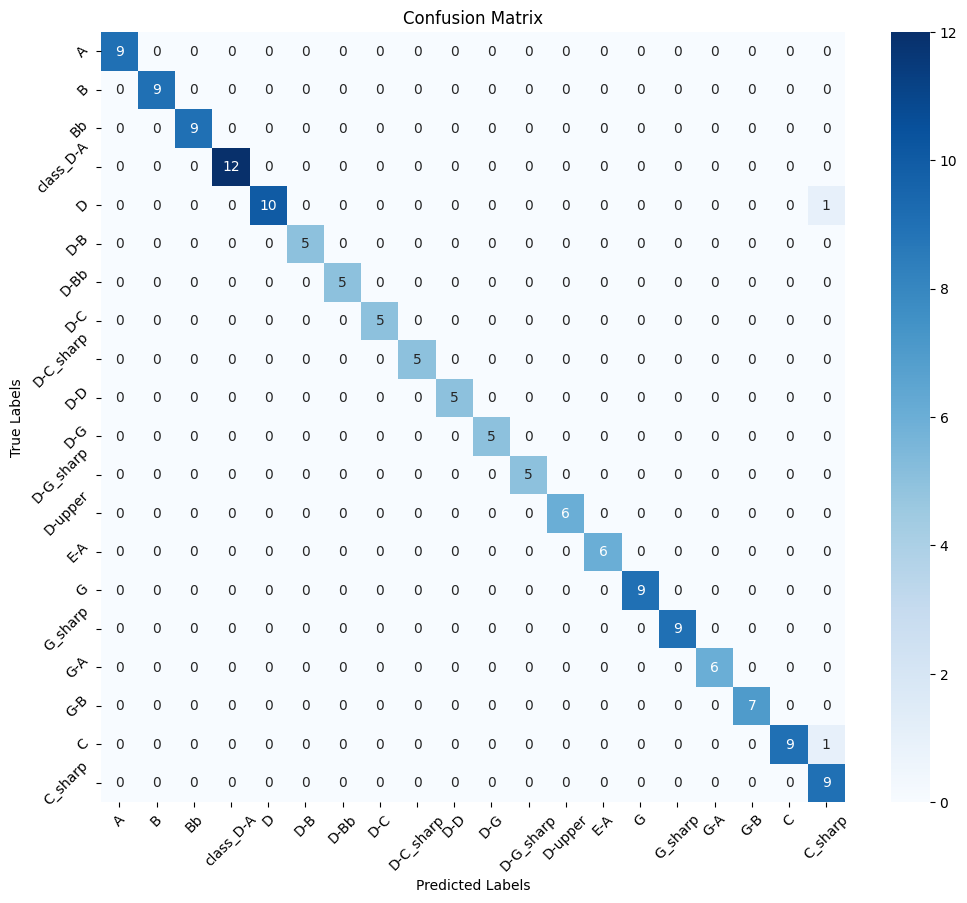

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
resnet34.eval()

# Create empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test data loader
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet34(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=to_folders, yticklabels=to_folders)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


### Resnet50: 75-25


>Testing resnet50 with 75-25 split




In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class_map = {"A":0, "B":1, "Bb":2, "class_D-A":3, "D":4, "D-B":5, 'D-Bb':6, 'D-C':7, 'D-C_sharp':8, 'D-D':9, 'D-G':10, 'D-G_sharp':11, 'D-upper':12, 'E-A':13, 'G':14, 'G_sharp':15, 'G-A':16, 'G-B':17, "С":18, "C_sharp": 19}
to_folders = ["A", "B", "Bb", "class_D-A", "D", "D-B", 'D-Bb', 'D-C', 'D-C_sharp', 'D-D', 'D-G', 'D-G_sharp', 'D-upper', 'E-A', 'G', 'G_sharp', 'G-A', 'G-B', 'С', "C_sharp"]

base_dir = '/content/drive/MyDrive/Dombyra_dataset/DL_MelSpectrograms/Melspectrograms/'
file_folders = []
file_labels = []
for to_folder in to_folders:
  for i, fn in enumerate(os.listdir(base_dir+to_folder)):
    file_folders.append(base_dir+to_folder+'/'+fn)
    file_labels.append(class_map[to_folder])

X_train_paths, X_test_paths, Y_train_paths, Y_test_paths = train_test_split(file_folders, file_labels, test_size=0.25, stratify=file_labels)


# Custom dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Create custom dataset
mel_dataset = MelSpectrogramDataset(X_train_paths, Y_train_paths, transform=transform)

# # Create data loader
data_loader = DataLoader(mel_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True).to(device)

# Modify the final fully connected layer to match the number of classes
num_classes = 20  # Change it according to your dataset
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes).to(device)
#ASSIGNING MORE WEIGHTS TO CLASSES OTHER THAN HUNGRY
#class_weights = torch.tensor([1.0, 2.0, 3.0, 2.0, 3.0]).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics at the end of each epoch
    epoch_loss = running_loss / 457
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{10}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


Epoch [1/10], Loss: 0.0386, Accuracy: 19.13%
Epoch [2/10], Loss: 0.0178, Accuracy: 65.15%
Epoch [3/10], Loss: 0.0103, Accuracy: 77.45%
Epoch [4/10], Loss: 0.0048, Accuracy: 89.98%
Epoch [5/10], Loss: 0.0037, Accuracy: 93.85%
Epoch [6/10], Loss: 0.0020, Accuracy: 96.36%
Epoch [7/10], Loss: 0.0021, Accuracy: 96.13%
Epoch [8/10], Loss: 0.0022, Accuracy: 95.90%
Epoch [9/10], Loss: 0.0008, Accuracy: 98.86%
Epoch [10/10], Loss: 0.0006, Accuracy: 99.32%


In [ ]:
# Create custom dataset for test set
test_dataset = MelSpectrogramDataset(X_test_paths, Y_test_paths, transform=transform)

# Create data loader for test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model on test data
resnet50.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.28%


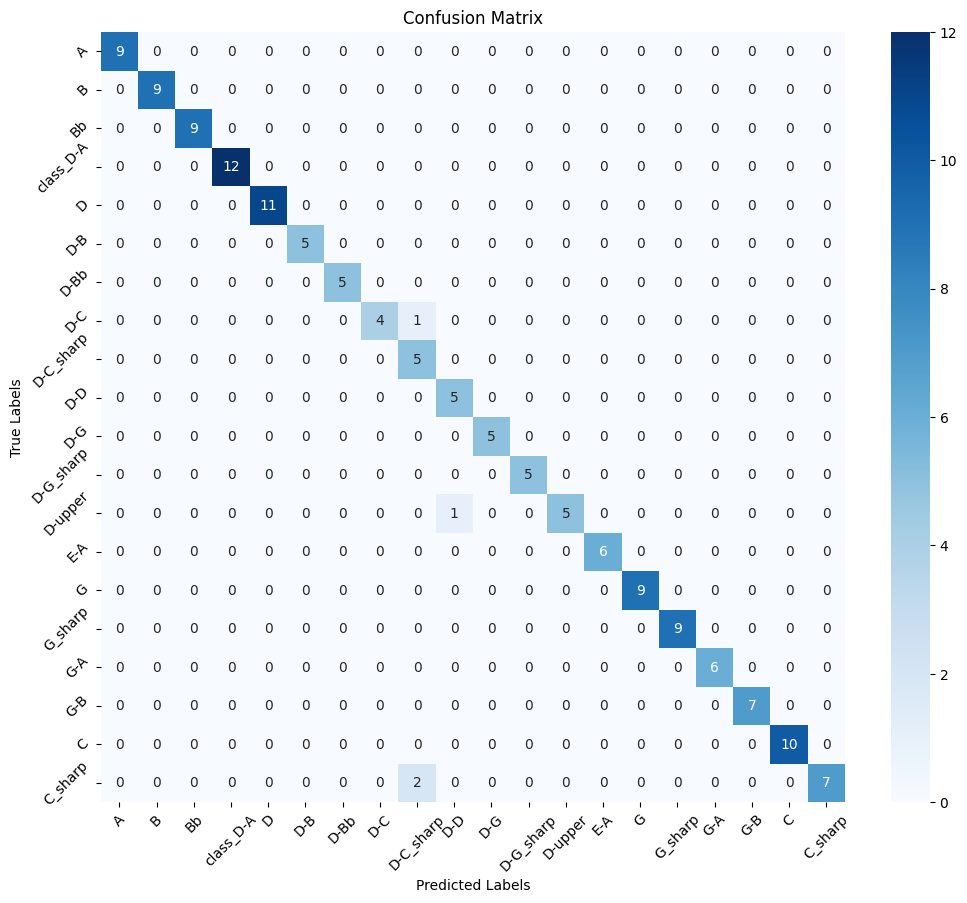

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

resnet50.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=to_folders, yticklabels=to_folders)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


###Resnet50: 70-30 split


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class_map = {"A":0, "B":1, "Bb":2, "class_D-A":3, "D":4, "D-B":5, 'D-Bb':6, 'D-C':7, 'D-C_sharp':8, 'D-D':9, 'D-G':10, 'D-G_sharp':11, 'D-upper':12, 'E-A':13, 'G':14, 'G_sharp':15, 'G-A':16, 'G-B':17, "С":18, "C_sharp": 19}
to_folders = ["A", "B", "Bb", "class_D-A", "D", "D-B", 'D-Bb', 'D-C', 'D-C_sharp', 'D-D', 'D-G', 'D-G_sharp', 'D-upper', 'E-A', 'G', 'G_sharp', 'G-A', 'G-B', 'С', "C_sharp"]

base_dir = '/content/drive/MyDrive/Dombyra_dataset/DL_MelSpectrograms/Melspectrograms/'
file_folders = []
file_labels = []
for to_folder in to_folders:
  for i, fn in enumerate(os.listdir(base_dir+to_folder)):
    file_folders.append(base_dir+to_folder+'/'+fn)
    file_labels.append(class_map[to_folder])

X_train_paths, X_test_paths, Y_train_paths, Y_test_paths = train_test_split(file_folders, file_labels, test_size=0.35, stratify=file_labels)


# Custom dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Create custom dataset
mel_dataset = MelSpectrogramDataset(X_train_paths, Y_train_paths, transform=transform)

# # Create data loader
data_loader = DataLoader(mel_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True).to(device)

# Modify the final fully connected layer to match the number of classes
num_classes = 20  # Change it according to your dataset
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes).to(device)
#ASSIGNING MORE WEIGHTS TO CLASSES OTHER THAN HUNGRY
#class_weights = torch.tensor([1.0, 2.0, 3.0, 2.0, 3.0]).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics at the end of each epoch
    epoch_loss = running_loss / 457
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{10}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0334, Accuracy: 22.63%
Epoch [2/10], Loss: 0.0167, Accuracy: 59.47%
Epoch [3/10], Loss: 0.0086, Accuracy: 81.32%
Epoch [4/10], Loss: 0.0049, Accuracy: 89.21%
Epoch [5/10], Loss: 0.0026, Accuracy: 95.00%
Epoch [6/10], Loss: 0.0015, Accuracy: 97.11%
Epoch [7/10], Loss: 0.0014, Accuracy: 97.37%
Epoch [8/10], Loss: 0.0018, Accuracy: 96.84%
Epoch [9/10], Loss: 0.0021, Accuracy: 95.26%
Epoch [10/10], Loss: 0.0011, Accuracy: 98.42%


In [ ]:
test_dataset = MelSpectrogramDataset(X_test_paths, Y_test_paths, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

resnet50.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet34(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.06%


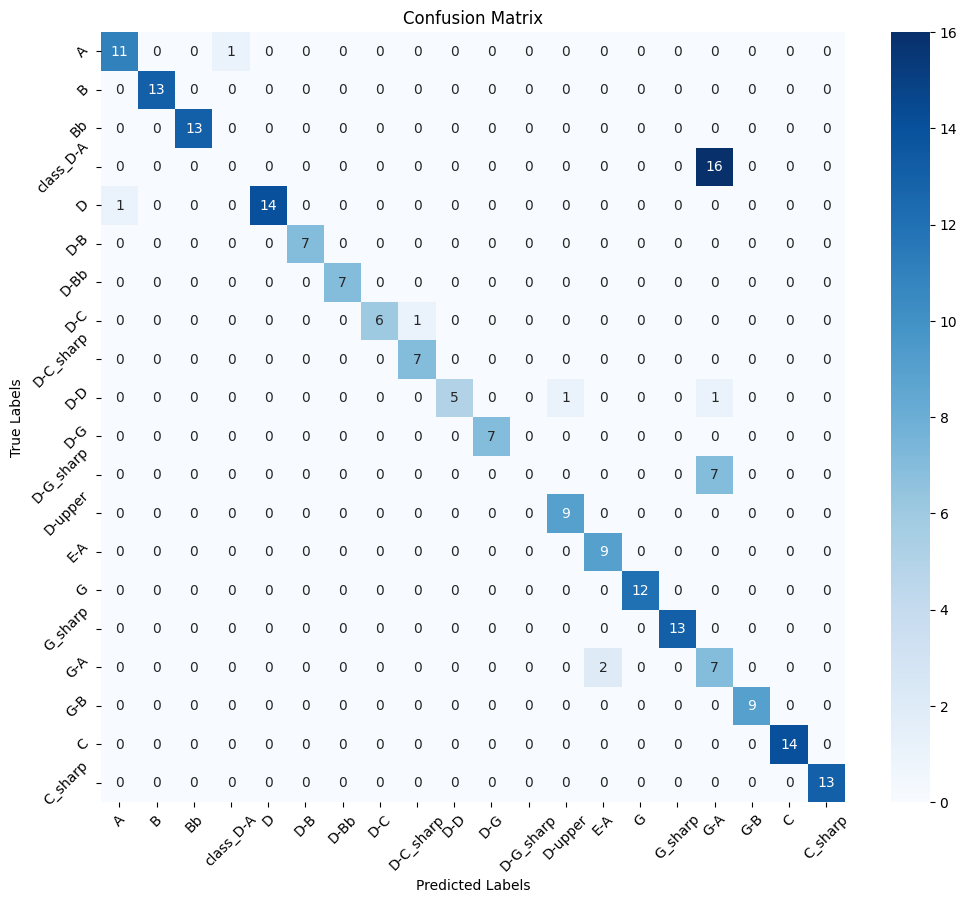

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

resnet50.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=to_folders, yticklabels=to_folders)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
